# RL training results

Plots over the full RL training log (`backend/data/rl/episode_log.jsonl`).
- Best fitness per episode (lower is better)
- Episode durations
- Seed performance summary

In [7]:
from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
sns.set_style("whitegrid")

In [8]:
def find_project_root() -> Path:
    """Walk upward to find repo root by markers (.git, pyproject.toml, backend/src)."""
    here = Path.cwd().resolve()
    for candidate in [here, *here.parents]:
        if (candidate / ".git").exists() or (candidate / "pyproject.toml").exists() or (candidate / "backend" / "src").exists():
            return candidate
    raise RuntimeError("Could not locate project root containing backend/src")

PROJECT_ROOT = find_project_root()
LOG_PATH = PROJECT_ROOT / "backend" / "data" / "rl" / "episode_log.jsonl"
print(f"Project root: {PROJECT_ROOT}")
print(f"Using log: {LOG_PATH}")

Project root: /Users/miki_przygoda/Projects/GitHub-Projects/genplan-template
Using log: /Users/miki_przygoda/Projects/GitHub-Projects/genplan-template/backend/data/rl/episode_log.jsonl


In [9]:
# Load the full episode log
if not LOG_PATH.exists():
    raise FileNotFoundError(f"Log file not found: {LOG_PATH}")

records = []
with LOG_PATH.open() as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        try:
            rec = json.loads(line)
            records.append(rec)
        except json.JSONDecodeError:
            continue

if not records:
    raise RuntimeError("No records loaded from episode_log.jsonl")

df = pd.DataFrame(records)
df = df.sort_values("episode")
df.head()

,episode,floor_id,seed,best_fitness,history,duration_s
190,1,101,section,3404.116899,"{'best': [21635.132118242127, 3712.59757875402...",86.774342
70,1,101,section,3439.553267,"{'best': [21638.915227415513, 3690.90986088676...",83.982682
10,1,101,section,3326.816143,"{'best': [21634.912918154023, 3678.04596864825...",104.896644
40,1,101,section,3443.870630,"{'best': [21638.915227415513, 3711.76237568701...",103.996457
2,1,101,mask_guided,6232.489116,"{'best': [106769.9981643383, 38578.85092075417...",184.361480


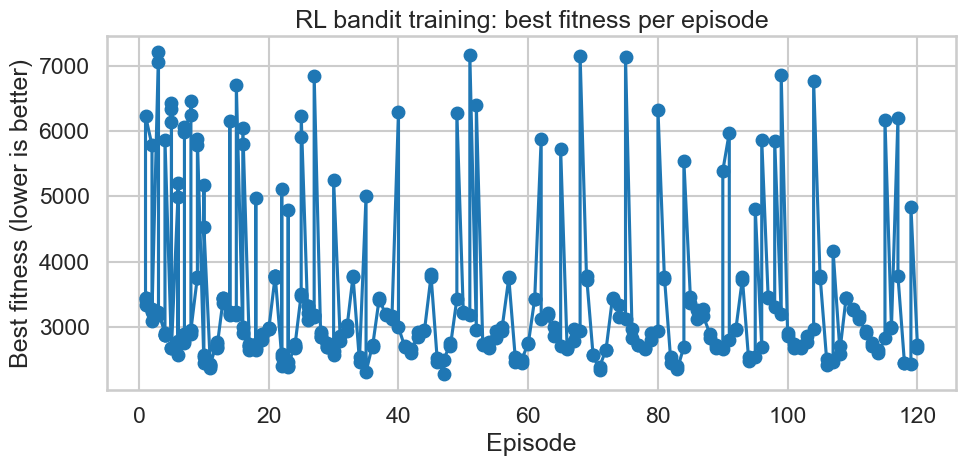

In [10]:
# Best fitness per episode
plt.figure(figsize=(10, 5))
plt.plot(df["episode"], df["best_fitness"], marker="o")
plt.xlabel("Episode")
plt.ylabel("Best fitness (lower is better)")
plt.title("RL bandit training: best fitness per episode")
plt.tight_layout()
plt.show()

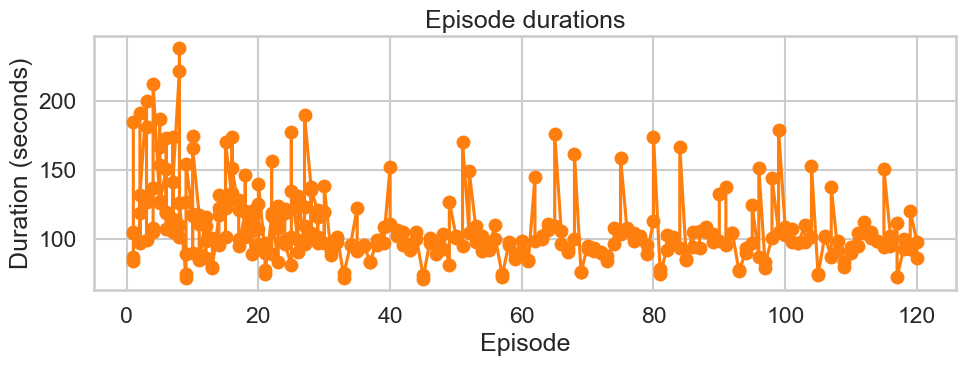

Avg duration: 109.9s | Median: 101.5s


In [11]:
# Episode durations
if "duration_s" in df:
    plt.figure(figsize=(10, 4))
    plt.plot(df["episode"], df["duration_s"], marker="o", color="tab:orange")
    plt.xlabel("Episode")
    plt.ylabel("Duration (seconds)")
    plt.title("Episode durations")
    plt.tight_layout()
    plt.show()
    print(f"Avg duration: {df['duration_s'].mean():.1f}s | Median: {df['duration_s'].median():.1f}s")

,count,best_fitness_mean,best_fitness_min
seed,,,
section,259,2945.565369,2275.343738
mask_guided,11,5817.229272,4163.311806
section_tight_mask,16,5913.853724,4977.565199
compact,10,5918.208765,4808.107693
mask_sparse,14,6083.728808,4782.760921


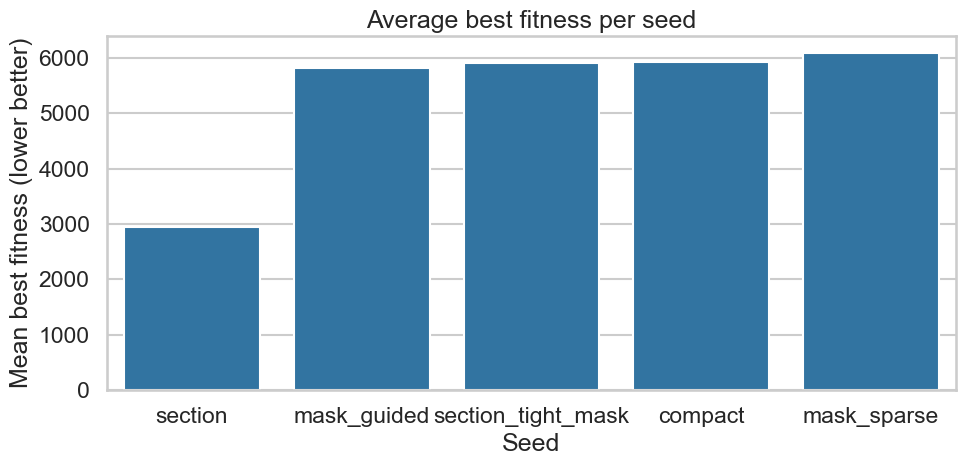

In [12]:
# Seed performance summary
seed_summary = (
    df.groupby("seed")
    .agg(count=("episode", "count"), best_fitness_mean=("best_fitness", "mean"), best_fitness_min=("best_fitness", "min"))
    .sort_values("best_fitness_mean")
)
display(seed_summary)

plt.figure(figsize=(10, 5))
sns.barplot(x=seed_summary.index, y=seed_summary["best_fitness_mean"], color="tab:blue")
plt.ylabel("Mean best fitness (lower better)")
plt.xlabel("Seed")
plt.title("Average best fitness per seed")
plt.tight_layout()
plt.show()